In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction'
))

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)

Event sizing: 477.3022253584152 928.0965530809582
Average time between events (seconds): 0.040273278440329144


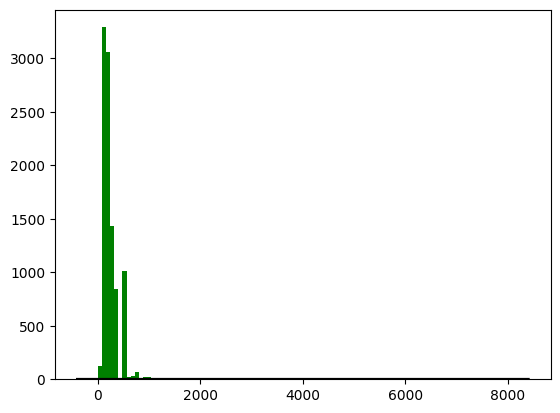

In [31]:
from scipy import stats

average_event_size = df['size'].mean()
event_sigma = df['size'].std()
average_time_between_events = df['time'].diff().mean()

print("Event sizing:", average_event_size, df['size'].std())
print("Average time between events (seconds):", average_time_between_events)

data = df['size'][:10_000]

ae, loce, scalee = stats.skewnorm.fit(data)

# Plot the PDF.
plt.figure()
plt.hist(data, bins=100, color='g')

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x,ae, loce, scalee)#.rvs(100)

plt.plot(x, p, 'k', linewidth=2)

Average spread: 1.2455639123625286


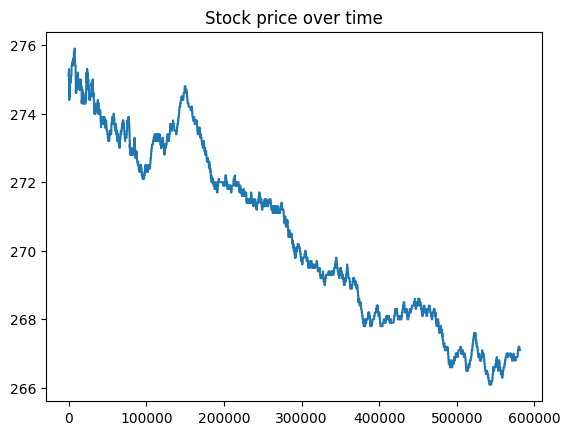

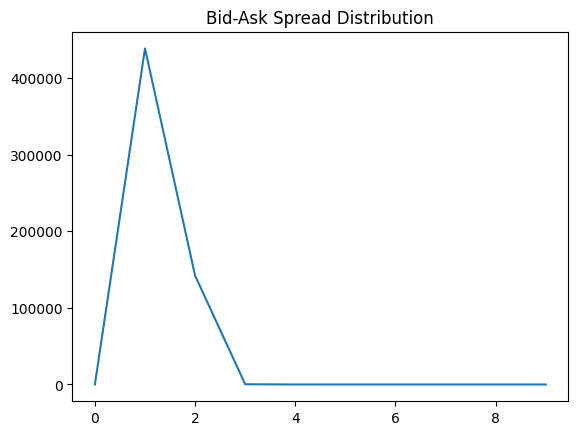

In [9]:
# 0.01 * 1000 = 10
spread = df['ask1_price'] - df['bid1_price']
print("Average spread:", np.mean(spread) / 100)

spreads = np.zeros((10, 1))

for i in range(0, 10):
    current_spread = df[(df['ask1_price'] - df['bid1_price']) == 100 * i]
    spreads[i] = len(current_spread)

plt.plot(df['bid1_price'] / 1000)
plt.title("Stock price over time")
plt.show()

plt.plot(spreads)
plt.title("Bid-Ask Spread Distribution")
plt.show()